<a href="https://colab.research.google.com/github/AdityaSharma404/Personalized-Text-Summarization/blob/main/Personalized_Text_Summarization_Implementation_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install seaborn
#pip install wordcloud
#!pip install pandas
#!pip install kaggle
#pip install --upgrade pip
#!pip install tensorflow
#import tensorflow as tf
#!pip list | grep tensorflow-gpu
#!pip uninstall tensorflow
#!pip install tensorflow[and-cuda]

In [ ]:
#python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

tqdm.pandas()
sns.set_style('dark')
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 14

In [ ]:
!pip install opendatasets

In [ ]:
## Before running below line, you might need Token from your Kaggle account and use the credentials to be use below

import opendatasets as od

od.download("https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail")


Skipping, found downloaded files in "./newspaper-text-summarization-cnn-dailymail" (use force=True to force download)


In [ ]:
# reading the csv file
import pandas as pds

file = ('newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv')
data = pds.read_csv(file)

# displaying the contents of the csv file
data.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


## Text Preprocessing

* Preprocessing of text data varies from one NLP task to another
* Typically in text classification tasks, you remove the stopwords from the sentence and also stem or lemmatize the words to their corresponding root words to reduce the vocabulary size. However, in language modelling we will refrain from doing so as these words can help our model undertand the underlying semantics of the language for it to produce texts of its own
* Therefore we will limit our text preprocessing to the following steps:
    1. Remove any extra lines or spaces from the text
    2. Remove any characters other than alphabets, numbers or period
    3. Tokenize the text
    4. Add a start and end token for the model to identify when the sentence starts and ends

In [ ]:
def text_cleaning(x):
    import re
    text = re.sub('\s+\n+', ' ', str(x))
    text = re.sub('[^a-zA-Z0-9\.]', ' ', text)
    text = text.split()

    text = [word for word in text]
    text = ' '.join(text)
    text = 'startseq '+text+' endseq'

    return text

In [ ]:
data["article"] = data["article"].apply(text_cleaning)

In [ ]:
data["highlights"] = data["highlights"].apply(text_cleaning)

In [ ]:
data["article"].head()

0    startseq By . Associated Press . PUBLISHED . 1...
1    startseq CNN Ralph Mata was an internal affair...
2    startseq A drunk driver who killed a young wom...
3    startseq CNN With a breezy sweep of his pen Pr...
4    startseq Fleetwood are the only team still to ...
Name: article, dtype: object

In [ ]:
data["highlights"].head()

0    startseq Bishop John Folda of North Dakota is ...
1    startseq Criminal complaint Cop used his role ...
2    startseq Craig Eccleston Todd 27 had drunk at ...
3    startseq Nina dos Santos says Europe must be r...
4    startseq Fleetwood top of League One after 2 0...
Name: highlights, dtype: object

In [ ]:
import tensorflow as tf
!pip list | grep tensorflow

tensorflow                       2.14.0
tensorflow-datasets              4.9.3
tensorflow-estimator             2.14.0
tensorflow-gcs-config            2.13.0
tensorflow-hub                   0.15.0
tensorflow-io-gcs-filesystem     0.34.0
tensorflow-metadata              1.14.0
tensorflow-probability           0.20.1


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

## Train-Val-Test Split
* Train: 85000
* Val: 10000
* Test: 5000

Since the datapoints were randomly sampled, we can go ahead and slice them using the indexes

In [ ]:
data.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,startseq By . Associated Press . PUBLISHED . 1...,startseq Bishop John Folda of North Dakota is ...
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,startseq CNN Ralph Mata was an internal affair...,startseq Criminal complaint Cop used his role ...
2,00027e965c8264c35cc1bc55556db388da82b07f,startseq A drunk driver who killed a young wom...,startseq Craig Eccleston Todd 27 had drunk at ...
3,0002c17436637c4fe1837c935c04de47adb18e9a,startseq CNN With a breezy sweep of his pen Pr...,startseq Nina dos Santos says Europe must be r...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,startseq Fleetwood are the only team still to ...,startseq Fleetwood top of League One after 2 0...


In [ ]:
train = data.iloc[:85000, :]
val = data.iloc[85000:95000, :].reset_index(drop=True)
test = data.iloc[95000:, :].reset_index(drop=True)

## Tokenization
* We will first fit the tokenizer on the entire train data to identify the vocabulary size. Then we will do our own analysis to identify the ideal vocab size


In [ ]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train['article'].tolist())
max_length = max(len(caption.split()) for caption in train['article'].tolist())

####  Sorting the words in vocabulary by their count¶


In [ ]:
df_vocab = pd.DataFrame(list(tokenizer.word_counts.items()), columns=['word','count'])
df_vocab.sort_values(by='count', ascending=False, inplace=True, ignore_index=True)
df_vocab.head()

,word,count
0,the,3351421
1,to,1596771
2,a,1435630
3,and,1371036
4,of,1358554


#### Wordcloud Visualization of the Vocabulary

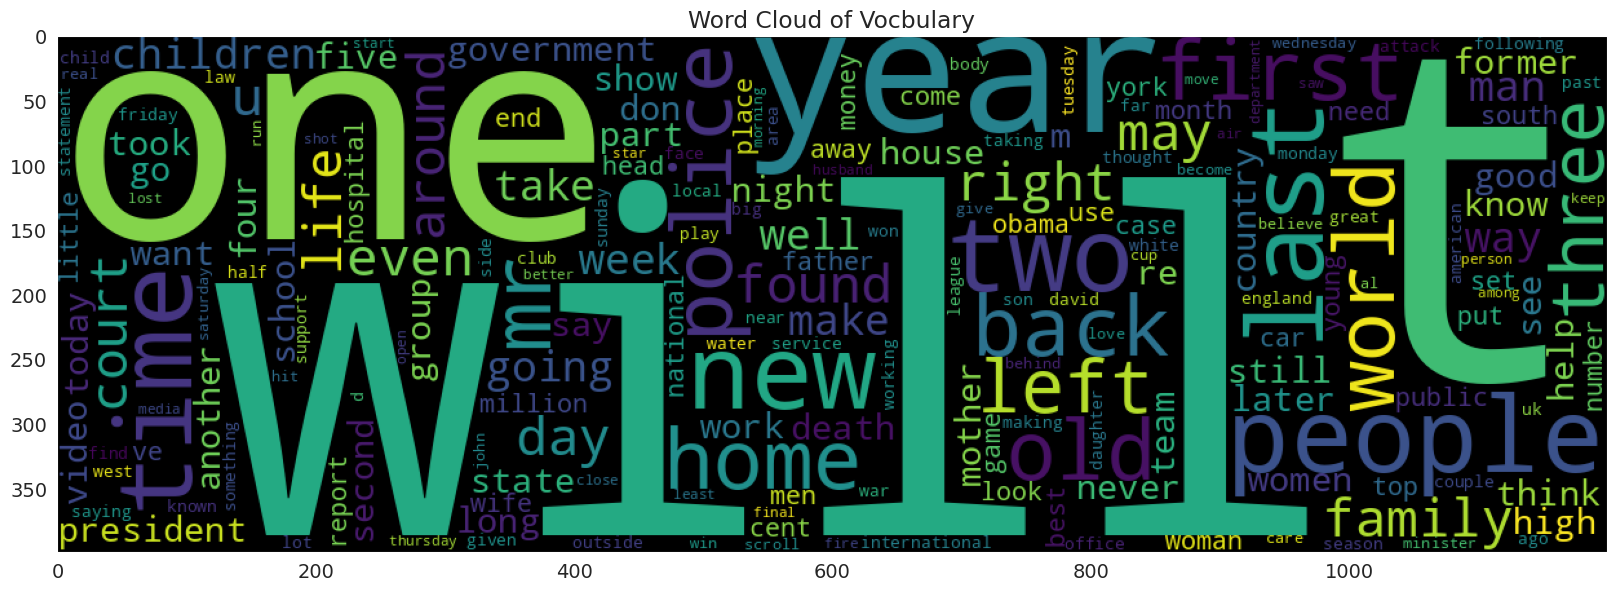

In [ ]:
words = ""
words += " ".join(df_vocab['word'].tolist())+" "
wordcloud = WordCloud(width = 1200, height = 400,
                background_color ='black',
                min_font_size = 10).generate(words)

plt.imshow(wordcloud)
plt.title('Word Cloud of Vocbulary')
plt.show()

#### Descriptive Stats of Vocab word counts
* Here we are able to see that most of the words present in our vocab i.e. about 75% of them occur very infrequently in the sentences (about 7 times at most).
* Therefore lets try to limit the number of words in our vocab where they atleast appear 50 times in the entire corpus

In [ ]:
df_vocab.describe()

,count
count,2.601320e+05
mean,2.283599e+02
std,1.000397e+04
min,1.000000e+00
25%,1.000000e+00
50%,3.000000e+00
75%,1.200000e+01
max,3.351421e+06


In [ ]:
df_vocab[df_vocab['count']>=50]

,word,count
0,the,3351421
1,to,1596771
2,a,1435630
3,and,1371036
4,of,1358554
...,...,...
32255,verratti,50
32256,bartley,50
32257,duwayne,50
32258,svalbard,50


#### We fit the Tokenizer to the limit vocab size¶
* Note: Any words that are not present in this limited vocab will be regarded as OOV or out of vocabulary

In [ ]:
vocab_size = len(df_vocab[df_vocab['count']>=50])
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train['article'].tolist())

### Sentence Length Analysis
* We need to both pad and truncated our sentences to a fixed length
* In order to identify the ideal sentence length, we will do an IQR analysis of the sentence lengths

In [ ]:
data['length'] = data['article'].progress_apply(lambda x: len(x.split(' ')))


100%|██████████| 287113/287113 [00:09<00:00, 28777.67it/s]


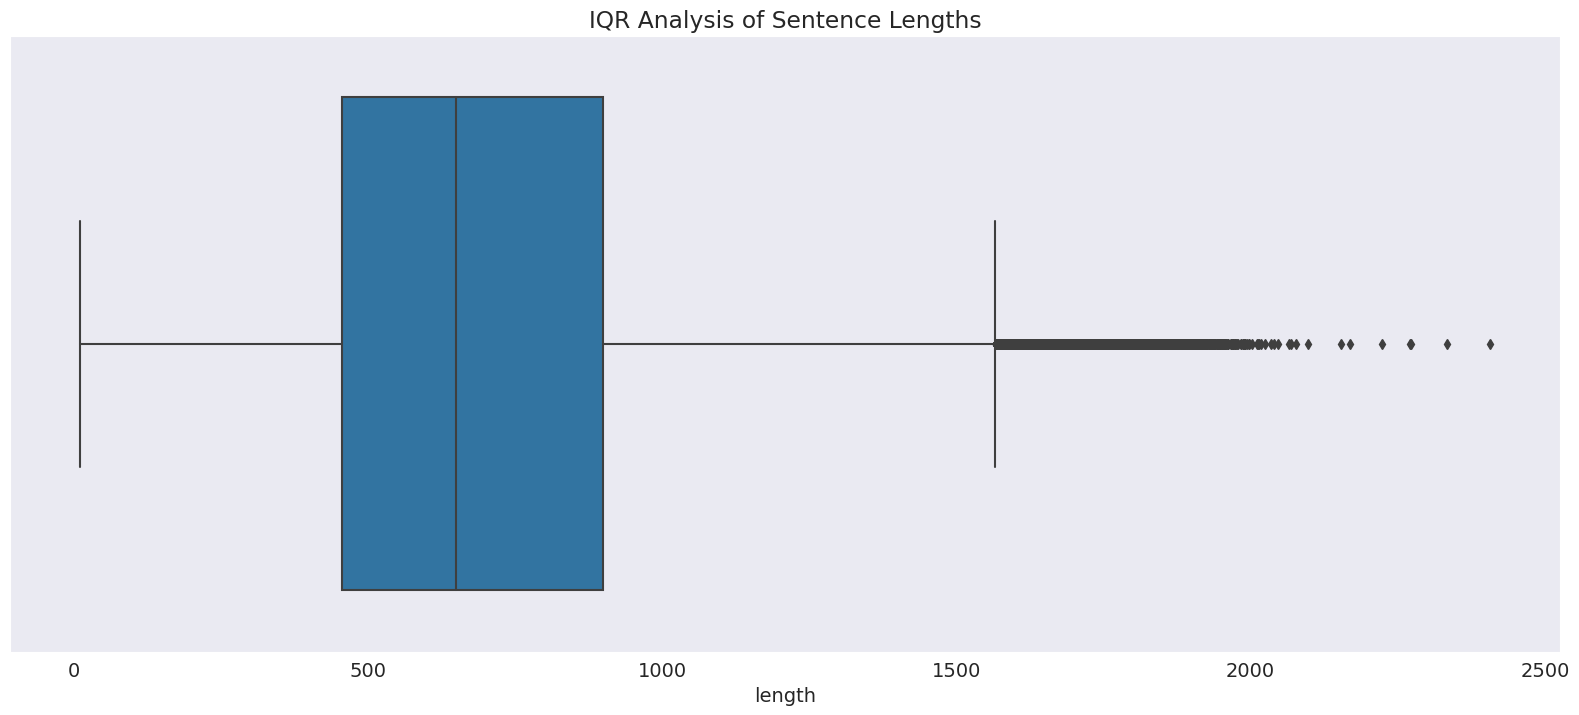

In [ ]:
sns.boxplot(x='length', data=data)
plt.title('IQR Analysis of Sentence Lengths')
plt.show()

In [ ]:
data.describe()

,length
count,287113.000000
mean,710.445703
std,344.261076
min,11.000000
25%,456.000000
50%,649.000000
75%,900.000000
max,2406.000000


#### By looking at our boxplot we will set the max_length to 1600
* Accomodates some of the outlier length sentences

In [ ]:
max_length = 1600
print(train.loc[0, 'article'])
print(tokenizer.texts_to_sequences([train.loc[0, 'article']])[0])

startseq By . Associated Press . PUBLISHED . 14 11 EST 25 October 2013 . . UPDATED . 15 36 EST 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda pictured of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low but officials feel it s important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bis

#### Data Generation
* For language modelling we need to arrange our data in such a way that the variable X contains a given sequence of words and the target y contains the next word
* Here we also need to make sure that the sentences are padded or truncated to the predetermined max length


Note: In the illustration given below all the prior words will be passed in the input and not just the seeded sequence of words. Hence the predicted word is added to the input sequence and then in turn is used for the prediction of the next word.
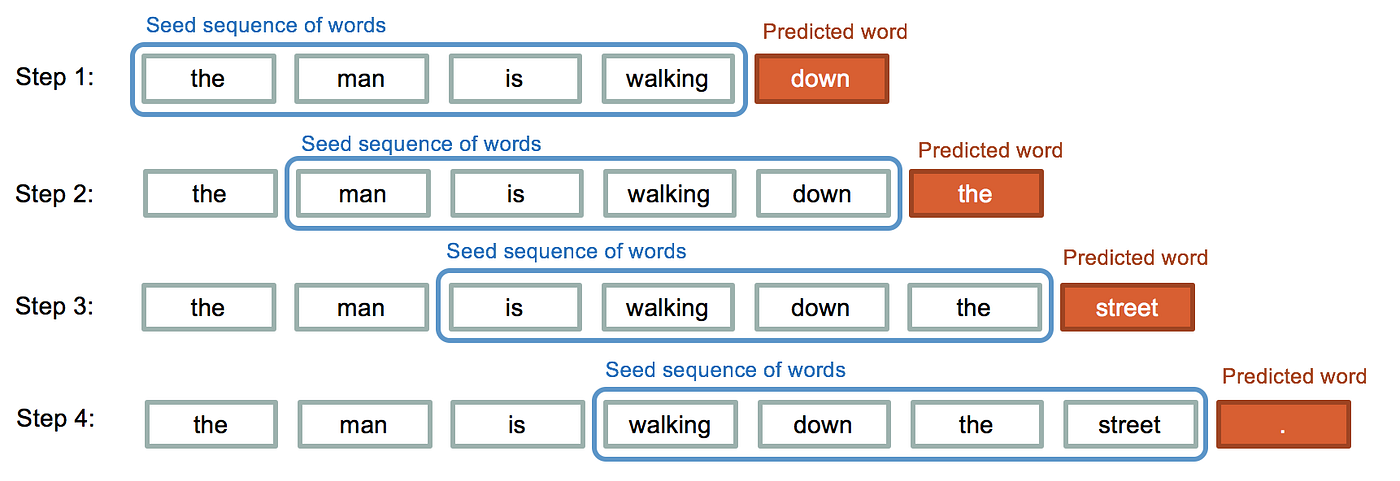

In [ ]:
seq = train.loc[0, 'article'].split()
X, y = [], []
for i in range(1,len(seq)):
    in_seq, out_seq = seq[:i], seq[i]
    X.append(' '.join(in_seq))
    y.append(out_seq)

example = pd.DataFrame(columns=['input','output'])
example['input'] = X
example['output'] = y
example

,input,output
0,startseq,By
1,startseq By,.
2,startseq By .,Associated
3,startseq By . Associated,Press
4,startseq By . Associated Press,.
...,...,...
196,startseq By . Associated Press . PUBLISHED . 1...,bishop
197,startseq By . Associated Press . PUBLISHED . 1...,is
198,startseq By . Associated Press . PUBLISHED . 1...,located
199,startseq By . Associated Press . PUBLISHED . 1...,.


In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, batch_size, tokenizer, vocab_size, max_length, shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X, y = self.__get_data(batch)
        return X, y

    def __get_data(self,batch):

        X, y = list(), list()
        captions = batch.loc[:, self.X_col].tolist()
        for caption in captions:
            seq = self.tokenizer.texts_to_sequences([caption])[0]
            max_len = self.max_length if len(seq) > self.max_length else len(seq)
            for i in range(1,max_len):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                X.append(in_seq)
                y.append(out_seq)

        X, y = np.array(X), np.array(y)

        return X, y

In [ ]:
train_gen = CustomDataGenerator(train, 'article', 16, tokenizer, vocab_size, max_length)
val_gen = CustomDataGenerator(val, 'article', 16, tokenizer, vocab_size, max_length)
test_gen = CustomDataGenerator(test, 'article', 16, tokenizer, vocab_size, max_length)

#### Modelling
* For building our language model, we will use a bidirectional LSTM, which is a type of RNN.
* But before we begin, with Bidirectional LSTM, here is a brief idea about what RNNs are.
A recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data. These deep learning algorithms are commonly used for ordinal or temporal problems, such as language translation, natural language processing (nlp), speech recognition, and image captioning
* Recurrent neural networks leverage backpropagation through time (BPTT) algorithm to determine the gradients, which is slightly different from traditional backpropagation as it is specific to sequence data. The principles of BPTT are the same as traditional backpropagation, where the model trains itself by calculating errors from its output layer to its input layer. These calculations allow us to adjust and fit the parameters of the model appropriately. BPTT differs from the traditional approach in that BPTT sums errors at each time step whereas feedforward networks do not need to sum errors as they do not share parameters across each layer.
* In the process of BPTT,the RNNs suffer from either of the two problems
1. Exploding Gradient: occur when the gradient is too large, and continues to become larger in the BPTT thus creating an unstable model. In this case, the model weights will grow too large, and they will eventually be represented as NaN.
2. Vanishing Gradient: occur when the gradient is too small, it continues to become smaller in the BPTT, updating the weight parameters until they become diminshingly small tending towards 0 and eventually become 0.
* To address the exploding gradient problem we can clip the gradients to threshold value, however, for vanishing gradient problem we make certain changes to the simple RNN architecture

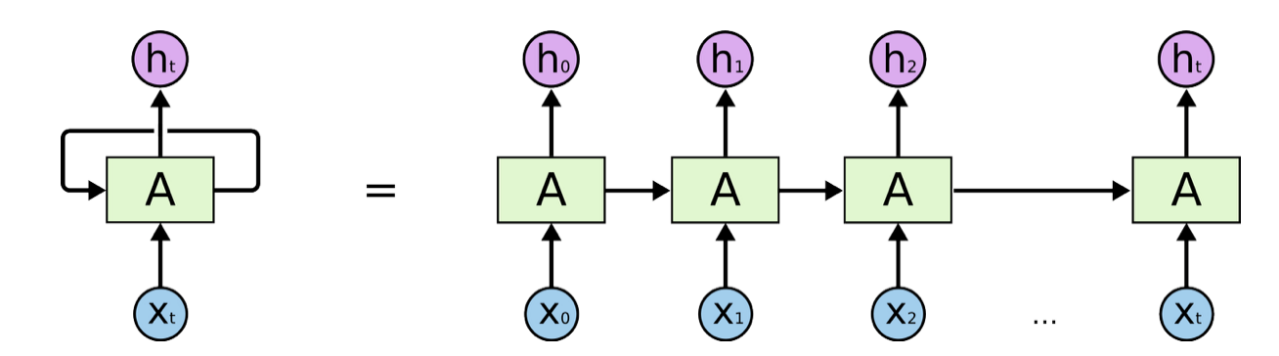

####LSTMs and GRUs
* **Long Short Term Memory (LSTM)**: This is a popular RNN architecture designed to address the problem of long term dependencies. if the previous state that is influencing the current prediction is not in the recent past, the RNN model may not be able to accurately predict the current state. As an example, let’s say we wanted to predict the italicized words in following, “Alice is allergic to nuts. She can’t eat peanut butter.” The context of a nut allergy can help us anticipate that the food that cannot be eaten contains nuts. However, if that context was a few sentences prior, then it would make it difficult, or even impossible, for the RNN to connect the information. To remedy this, LSTMs have “cells” in the hidden layers of the neural network, which have three gates–an input gate, an output gate, and a forget gate. These gates control the flow of information which is needed to predict the output in the network.

* **Gated Recurrent Units (GRUs)**: This RNN variant is similar the LSTMs as it also works to address the short-term memory problem of RNN models. Instead of using a “cell state” regulate information, it uses hidden states, and instead of three gates, it has two—a reset gate and an update gate. Similar to the gates within LSTMs, the reset and update gates control how much and which information to retain.

* **Bidirectional recurrent neural networks (BRNN)**: These are a variant network architecture of RNNs. While unidirectional RNNs can only drawn from previous inputs to make predictions about the current state, bidirectional RNNs pull in future data to improve the accuracy of it. If we return to the example of “feeling under the weather” earlier in this article, the model can better predict that the second word in that phrase is “under” if it knew that the last word in the sequence is “weather.”

Source: https://www.ibm.com/topics/recurrent-neural-networks

For more information please follow these resources:

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

https://towardsdatascience.com/beautifully-illustrated-nlp-models-from-rnn-to-transformer-80d69faf2109





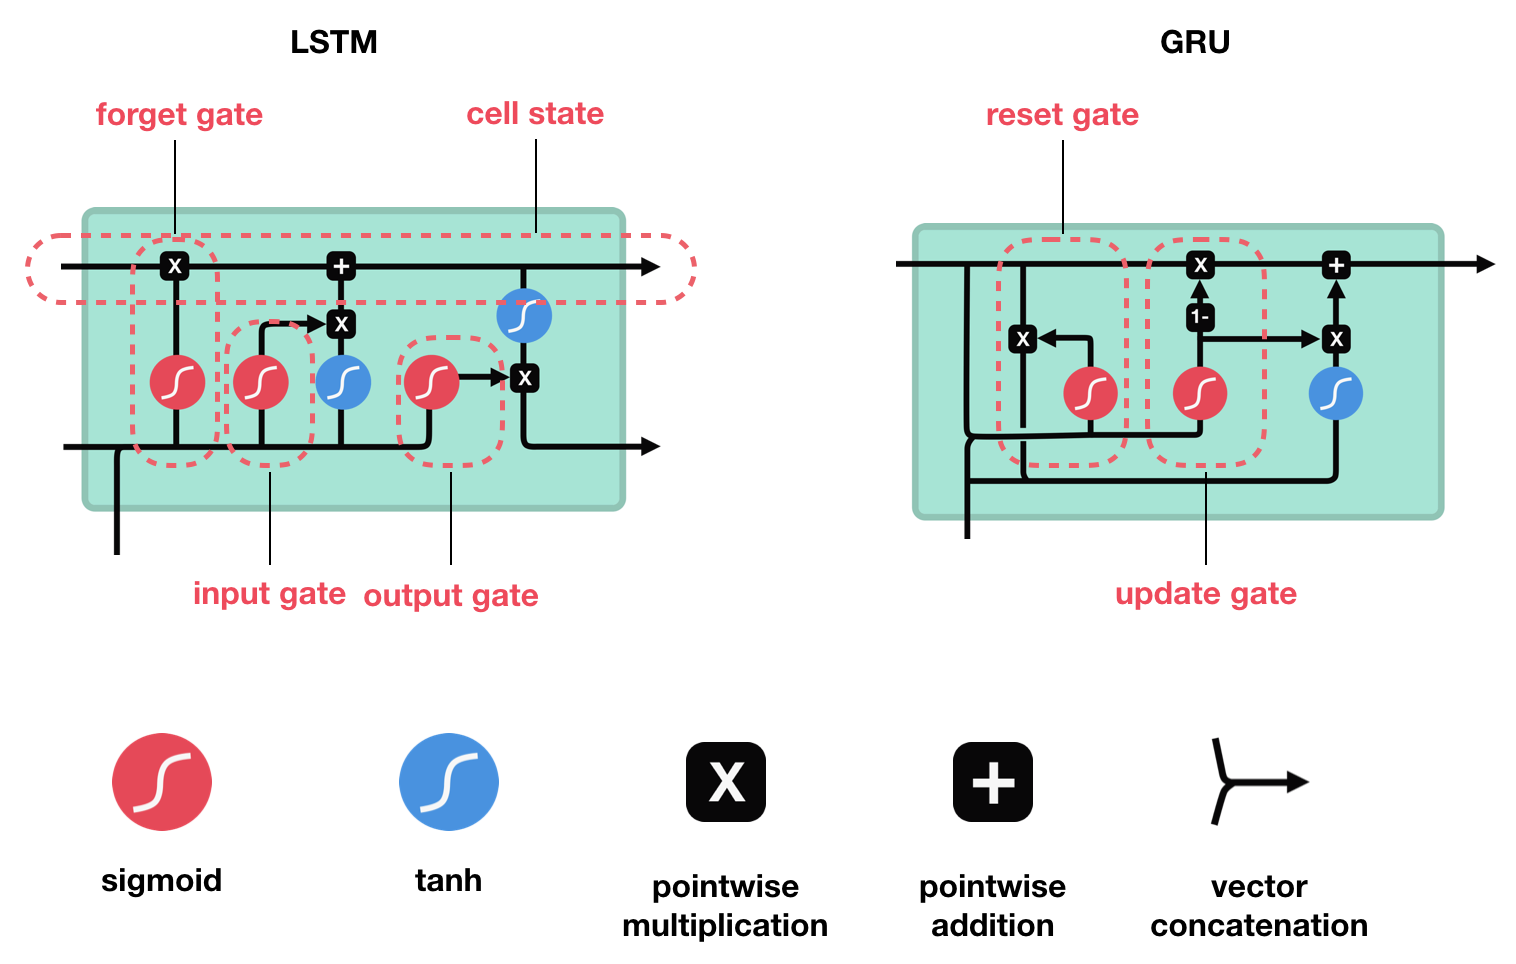

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional, Dense, Input)

In [ ]:
input_layer = Input(shape=(50,))
x = Embedding(vocab_size, 64)(input_layer)
x = Bidirectional(LSTM(100))(x)
output_layer = Dense(vocab_size, activation='softmax')(x)

model = Model(inputs=[input_layer], outputs=output_layer)
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam())

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 64)            2064640   
                                                                 
 bidirectional (Bidirection  (None, 200)               132000    
 al)                                                             
                                                                 
 dense (Dense)               (None, 32260)             6484260   
                                                                 
Total params: 8680900 (33.12 MB)
Trainable params: 8680900 (33.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

es = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 8:
        return lr
    else:
        return lr * tf.math.exp(-0.1*epoch)


lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=25, callbacks=[checkpoint, es, lr_scheduler])

NameError: ignored